In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/34_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/40_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/22_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/27_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/28_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/26_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/38_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/39_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/24_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/tr

In [ ]:
!pip -q install --no-cache-dir pretrainedmodels==0.7.4 efficientnet-pytorch==0.7.1


In [3]:
# ============================================================
# RetinaBench — 6-Model Retinal Vessel Segmentation (DRIVE)
# U-Net, Attention U-Net (MAnet), ResUNet (Unet+ResNet encoder),
# DeepLabV3, U-Net++, PSPNet — via segmentation-models-pytorch
# Saves: best.pth, best.onnx (best-effort), threshold.json, overlays,
# comparison_table.csv; packs everything into a single ZIP.
# ============================================================

# ---------- Installs (keep torch preinstalled) ----------
!pip -q uninstall -y segmentation-models-pytorch timm albumentations albucore opencv-python opencv-python-headless scikit-image scipy onnx || true
!pip -q install --upgrade --no-cache-dir timm==0.9.2
!pip -q install --no-deps --upgrade --no-cache-dir segmentation-models-pytorch==0.3.3
!pip -q install --upgrade --no-cache-dir opencv-python-headless==4.9.0.80 scikit-image==0.21.0 scipy==1.11.4 pandas
# SMP 0.3.x expects these legacy deps:
!pip -q install --upgrade --no-cache-dir pretrainedmodels==0.7.4 efficientnet-pytorch==0.7.1
# Stable ONNX + ml_dtypes combo to avoid float4_e2m1fn error
!pip -q install --upgrade --no-cache-dir onnx==1.16.2 ml_dtypes>=0.5.0

# ---------- Imports ----------
import os, json, glob, zipfile
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ROOT = Path("/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE")
WORK = Path("/kaggle/working/retinabench"); WORK.mkdir(parents=True, exist_ok=True)

print("Device:", DEVICE)

# ---------- DRIVE paths ----------
TR_IMG = ROOT/"training/images"
TR_GT  = ROOT/"training/1st_manual"
TR_FOV = ROOT/"training/mask"
TE_IMG = ROOT/"test/images"
TE_GT  = ROOT/"test/1st_manual"    # may not exist in some mirrors
TE_FOV = ROOT/"test/mask"
HAS_TEST_GT = TE_GT.exists() and len(list(TE_GT.glob("*.gif"))) > 0
print("Has test ground truth:", HAS_TEST_GT)

# ---------- Helpers ----------
def read_green(path):
    img = np.array(Image.open(str(path)))
    return img[...,1] if img.ndim==3 else img.astype(np.uint8)

def read_mask(path):
    if path is None:
        return None
    try:
        m = np.array(Image.open(str(path)))
    except FileNotFoundError:
        return None
    if m.ndim==3: m = m[...,0]
    return (m>0).astype(np.uint8)

def preprocess_green(g):
    g = g.astype(np.float32)
    g = (g - g.mean()) / (g.std() if g.std()>0 else 1.0)
    g = np.clip(g, -3, 3); g = ((g + 3)/6*255).astype(np.uint8)
    g = cv2.createCLAHE(2.0,(8,8)).apply(g)
    g = (255.0*(g/255.0)**(1/1.2)).astype(np.uint8)
    return g

def pad_to_32(img):
    h,w = img.shape
    H = (h+31)//32*32; W = (w+31)//32*32
    pad = np.zeros((H,W), img.dtype); pad[:h,:w] = img
    return pad, (h,w)

def id_from_path(p):
    s = Path(p).stem
    return s[:2]

def paired_training_files():
    imgs = sorted(TR_IMG.glob("*.tif"))
    out = []
    for i in imgs:
        k = id_from_path(i.name)
        gt  = TR_GT / f"{k}_manual1.gif"
        fov = TR_FOV / f"{k}_training_mask.gif"
        if gt.exists() and fov.exists():
            out.append((i, gt, fov))
    return out

def paired_test_files():
    imgs = sorted(TE_IMG.glob("*.tif"))
    out = []
    for i in imgs:
        k = id_from_path(i.name)
        gt  = TE_GT / f"{k}_manual1.gif" if HAS_TEST_GT else None
        fov = TE_FOV / f"{k}_test_mask.gif"
        out.append((i, gt if (HAS_TEST_GT and gt and gt.exists()) else None, fov))
    return out

# ---------- Dataset ----------
class DriveSegDataset(Dataset):
    def __init__(self, triples, augment=False):
        self.triples = triples
        self.augment = augment
    def __len__(self): return len(self.triples)
    def __getitem__(self, idx):
        p_img, p_gt, p_fov = self.triples[idx]
        g   = preprocess_green(read_green(p_img))
        fov = read_mask(p_fov)
        if fov is None: fov = np.ones_like(g, dtype=np.uint8)
        g = (g * fov).astype(np.uint8)

        gt = read_mask(p_gt)
        if gt is None:
            gt = np.zeros_like(fov, dtype=np.uint8)  # test w/o GT → blank

        if self.augment:
            if np.random.rand()<0.5:
                g = np.flip(g,1).copy(); gt = np.flip(gt,1).copy(); fov = np.flip(fov,1).copy()
            if np.random.rand()<0.5:
                g = np.flip(g,0).copy(); gt = np.flip(gt,0).copy(); fov = np.flip(fov,0).copy()

        g_pad, orig = pad_to_32(g); gt_pad,_ = pad_to_32(gt); fov_pad,_ = pad_to_32(fov)
        x = torch.from_numpy(g_pad[None].astype(np.float32)/255.0)
        y = torch.from_numpy(gt_pad[None].astype(np.float32))
        f = torch.from_numpy(fov_pad[None].astype(np.float32))
        return x, y, f, orig, str(Path(p_img).name)

# ---------- Split train/val by image (no leakage) ----------
all_tr = paired_training_files()            # 20 images
val_ids = set(sorted([id_from_path(p[0].name) for p in all_tr])[:4])  # 4 for val
train_triples = [t for t in all_tr if id_from_path(t[0].name) not in val_ids]
val_triples   = [t for t in all_tr if id_from_path(t[0].name) in val_ids]
test_triples  = paired_test_files()

print(f"Train images: {len(train_triples)} | Val images: {len(val_triples)} | Test images: {len(test_triples)}")

BATCH=2
train_dl = DataLoader(DriveSegDataset(train_triples, augment=True),  batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(DriveSegDataset(val_triples,   augment=False), batch_size=1,     shuffle=False, num_workers=2)
# Use 0 workers on test to surface any path issues clearly
test_dl  = DataLoader(DriveSegDataset(test_triples,  augment=False), batch_size=1,     shuffle=False, num_workers=0)

# ---------- Loss & metrics ----------
bce = nn.BCEWithLogitsLoss()

def dice_coeff(pred, target, mask, eps=1e-6):
    p = (pred>0.5).float()
    t = (target>0.5).float()
    m = (mask>0.5).float()
    inter = (p*m*t).sum(dim=(1,2,3))
    den   = (p*m).sum(dim=(1,2,3)) + (t*m).sum(dim=(1,2,3))
    return ((2*inter + eps)/(den + eps)).mean().item()

def dice_loss(logits, target, mask, eps=1e-6):
    prob = torch.sigmoid(logits)
    inter = (prob*target*mask).sum(dim=(1,2,3))
    den   = (prob*mask).sum(dim=(1,2,3)) + (target*mask).sum(dim=(1,2,3))
    dice = (2*inter + eps)/(den + eps)
    return 1 - dice.mean()

# ---------- Model zoo ----------
def make_model(name):
    if name=="unet":      return smp.Unet("resnet34", in_channels=1, classes=1)
    if name=="attn_unet": return smp.MAnet("resnet34", in_channels=1, classes=1)
    if name=="resunet":   return smp.Unet("resnet34", in_channels=1, classes=1)  # ResNet encoder ~= ResUNet
    if name=="deeplabv3": return smp.DeepLabV3("resnet34", in_channels=1, classes=1)
    if name=="unetpp":    return smp.UnetPlusPlus("resnet34", in_channels=1, classes=1)
    if name=="pspnet":    return smp.PSPNet("resnet34", in_channels=1, classes=1)
    raise ValueError(name)

MODEL_LIST = ["unet","attn_unet","resunet","deeplabv3","unetpp","pspnet"]

# ---------- Training / Validation ----------
def run_one_model(name, epochs=30, lr=1e-3):
    print("\n============================")
    print("Training:", name)
    print("============================")
    out = WORK/name
    (out/"overlays_val").mkdir(parents=True, exist_ok=True)
    (out/"overlays_test").mkdir(parents=True, exist_ok=True)

    model = make_model(name).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_dice, best_state = -1.0, None

    for ep in range(1, epochs+1):
        model.train(); tr_loss = 0.0
        for xb, yb, fb, _, _ in train_dl:
            xb, yb, fb = xb.to(DEVICE), yb.to(DEVICE), fb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = 0.5*bce(logits, yb) + 0.5*dice_loss(logits, yb, fb)
            loss.backward(); opt.step()
            tr_loss += loss.item()*xb.size(0)
        tr_loss /= len(train_dl.dataset)

        model.eval(); dices=[]
        with torch.no_grad():
            for xb, yb, fb, _, _ in val_dl:
                xb, yb, fb = xb.to(DEVICE), yb.to(DEVICE), fb.to(DEVICE)
                pr = torch.sigmoid(model(xb))
                dices.append(dice_coeff(pr, yb, fb))
        val_dice = float(np.mean(dices)) if dices else 0.0
        print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} | val Dice {val_dice:.4f}")
        if val_dice>best_dice:
            best_dice = val_dice
            best_state = {k:v.detach().cpu() for k,v in model.state_dict().items()}

    model.load_state_dict(best_state)

    # threshold sweep on VAL
    thrs = np.linspace(0.30, 0.70, 9)
    best_thr, best_dice_thr, best_iou_thr = 0.5, -1, -1
    val_rows=[]
    with torch.no_grad():
        for thr in thrs:
            dices,ious=[],[]
            for xb, yb, fb, orig, nm in val_dl:
                xb=xb.to(DEVICE)
                p = torch.sigmoid(model(xb)).cpu().numpy()[0,0]
                h,w = orig
                p = p[:h,:w]
                m = fb.numpy()[0,0][:h,:w]>0.5
                t = yb.numpy()[0,0][:h,:w]>0.5
                y = (p>thr) & m
                inter = (y & t).sum()
                dice = (2*inter)/ (y.sum()+t.sum()+1e-6)
                iou  = inter / ((y|t).sum()+1e-6)
                dices.append(dice); ious.append(iou)
            d,i = float(np.mean(dices)), float(np.mean(ious))
            val_rows.append({"thr":thr,"dice":d,"iou":i})
            if d>best_dice_thr: best_dice_thr, best_iou_thr, best_thr = d,i,thr
    pd.DataFrame(val_rows).to_csv(out/"val_threshold_sweep.csv", index=False)

    # save weights + threshold
    torch.save(model.state_dict(), out/"best.pth")
    with open(out/"threshold.json","w") as f: json.dump({"best_threshold": float(best_thr)}, f)

    # export ONNX (best-effort; won't crash training)
    try:
        import onnx  # ensure import works with our pins
        xb = torch.zeros(1,1,576,576).to(DEVICE)
        torch.onnx.export(model, xb, out/"best.onnx",
                          opset_version=12, input_names=["input"], output_names=["logits"])
        print("ONNX export: OK ->", out/"best.onnx")
    except Exception as e:
        print("ONNX export skipped due to error:", e)

    # VAL overlays
    with torch.no_grad():
        for xb, yb, fb, orig, nm in val_dl:
            xb=xb.to(DEVICE)
            p = torch.sigmoid(model(xb)).cpu().numpy()[0,0]
            h,w = orig
            p = (p[:h,:w] > best_thr).astype(np.uint8)
            f = fb.numpy()[0,0][:h,:w]>0.5
            p = (p & f).astype(np.uint8)*255
            k = nm[0][:2]
            rgb = np.array(Image.open(str(TR_IMG / f"{k}_training.tif")))[:,:,::-1]
            over = rgb.copy(); over[p>0]=(0,0,255)
            cv2.imwrite(str(out/"overlays_val"/f"{k}_val_overlay.png"), cv2.addWeighted(rgb,1.0,over,0.35,0))

    # TEST overlays + metrics (if GT available)
    test_dice = test_iou = None
    if len(test_triples)>0:
        dices,ious=[],[]
        with torch.no_grad():
            for xb, yb, fb, orig, nm in test_dl:
                xb=xb.to(DEVICE)
                p = torch.sigmoid(model(xb)).cpu().numpy()[0,0]
                h,w = orig
                p = (p[:h,:w] > best_thr).astype(np.uint8)
                f = fb.numpy()[0,0][:h,:w]>0.5
                p = (p & f).astype(np.uint8)*255

                k = nm[0][:2]
                rgb = np.array(Image.open(str(TE_IMG / f"{k}_test.tif")))[:,:,::-1]
                over = rgb.copy(); over[p>0]=(0,0,255)
                cv2.imwrite(str(out/"overlays_test"/f"{k}_test_overlay.png"), cv2.addWeighted(rgb,1.0,over,0.35,0))

                if HAS_TEST_GT:
                    gt = read_mask(TE_GT / f"{k}_manual1.gif")
                    if gt is not None:
                        gt = gt[:h,:w]>0
                        y  = p[:h,:w]>0
                        inter=(y & gt).sum()
                        dices.append((2*inter)/(y.sum()+gt.sum()+1e-6))
                        ious.append(inter/((y|gt).sum()+1e-6))
        if HAS_TEST_GT and dices:
            test_dice, test_iou = float(np.mean(dices)), float(np.mean(ious))

    row = {"model":name, "val_dice":float(best_dice_thr), "val_iou":float(best_iou_thr),
           "thr":float(best_thr), "test_dice":test_dice, "test_iou":test_iou}
    print("Best threshold:", best_thr, "| Val Dice:", best_dice_thr, "| Val IoU:", best_iou_thr,
          "| Test Dice:", test_dice, "| Test IoU:", test_iou)
    return row

# ---------- Train all six & compare ----------
results=[]
for name in MODEL_LIST:
    results.append(run_one_model(name, epochs=30, lr=1e-3))

df = pd.DataFrame(results)
df.to_csv(WORK/"comparison_table.csv", index=False)
print("\n=== COMPARISON (val metrics) ===")
print(df)

# ---------- Zip everything for one-click download ----------
ZIP_PATH = "/kaggle/working/retinabench_artifacts.zip"
with zipfile.ZipFile(ZIP_PATH, 'w', zipfile.ZIP_DEFLATED) as z:
    for p in WORK.rglob("*"):
        z.write(p, p.relative_to(WORK.parent))  # keep folder structure
print("Zipped to:", ZIP_PATH)

print("\nSaved directories:")
for name in MODEL_LIST:
    print(f"- {WORK/name}")
print("\nArtifacts zip:", ZIP_PATH)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 272.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 277.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 292.6 MB/s eta 0:00:00 0:00:01m
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", bu

ORT providers: ['AzureExecutionProvider', 'CPUExecutionProvider'] | using: ['CPUExecutionProvider']
       model  threshold  vessel_pixels  latency_ms
0       unet       0.30          33475       381.6
1  attn_unet       0.50          33784       437.6
2    resunet       0.30          33304       374.2
3  deeplabv3       0.50          37765      1071.9
4     unetpp       0.30          32886       909.2
5     pspnet       0.45          41193       112.5
Saved to: /kaggle/working/multimodel_outputs


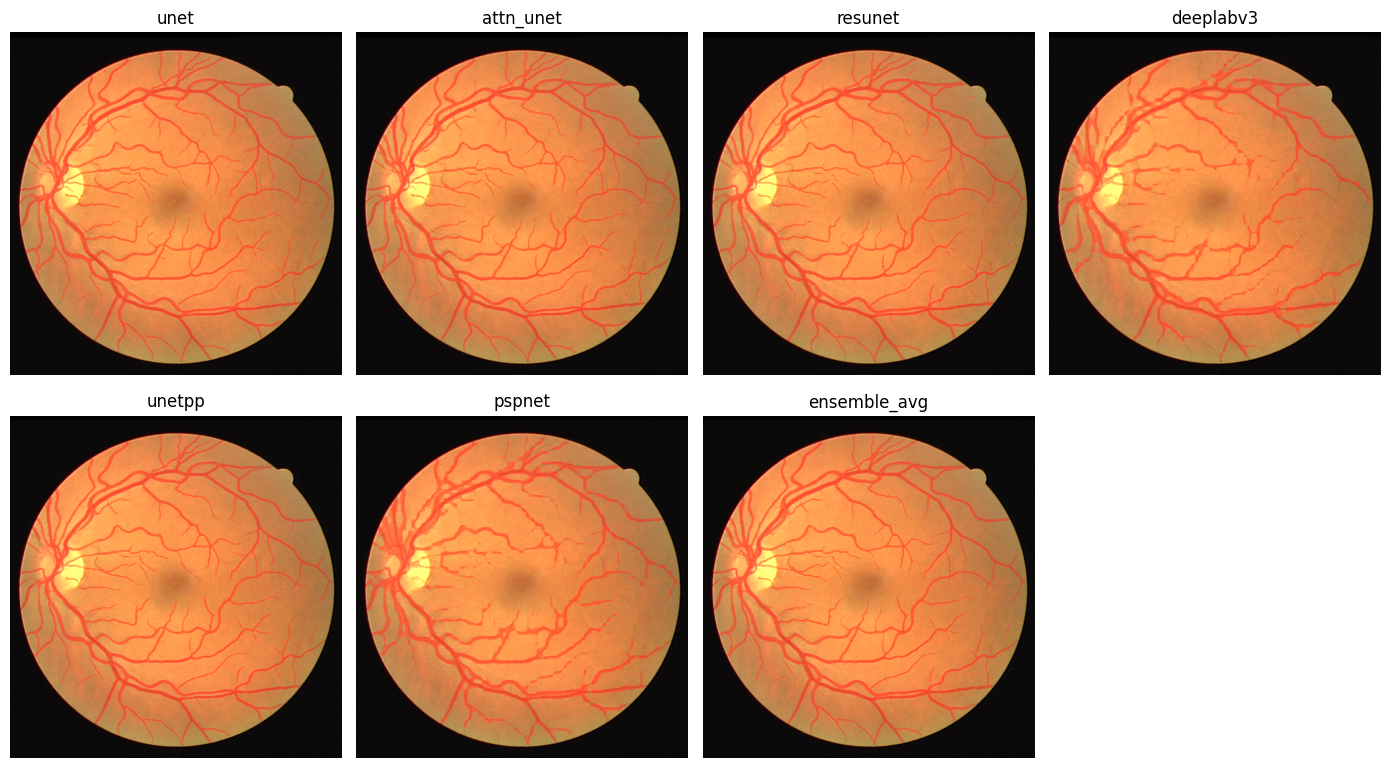

In [11]:
# === Multi-model ONNX inference on ONE test image (saves masks/overlays & a CSV) ===
# Models: unet, attn_unet, resunet, deeplabv3, unetpp, pspnet
# (Assumes /kaggle/working/retinabench/<model>/best.onnx + threshold.json exist)

# If needed:
# !pip -q install --no-cache-dir onnxruntime==1.16.3

import os, json, time, cv2, numpy as np, onnxruntime as ort, pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

BASE = Path("/kaggle/working/retinabench")
MODELS = ["unet","attn_unet","resunet","deeplabv3","unetpp","pspnet"]
OUTDIR = Path("/kaggle/working/multimodel_outputs"); OUTDIR.mkdir(parents=True, exist_ok=True)

IMG_PATH = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/images/01_test.tif"
FOV_PATH = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/mask/01_test_mask.gif"

def preprocess_green(bgr):
    g = bgr[...,1].astype(np.float32)
    g = (g - g.mean()) / (g.std() if g.std()>0 else 1.0)
    g = np.clip(g, -3, 3); g = ((g+3)/6*255).astype(np.uint8)
    g = cv2.createCLAHE(2.0,(8,8)).apply(g)
    return (255.0*(g/255.0)**(1/1.2)).astype(np.uint8)

def read_fov_mask(path, shape_hw):
    try:
        m = np.array(Image.open(path))
        if m.ndim==3: m = m[...,0]
        return (m>0)
    except Exception:
        h,w = shape_hw
        return np.ones((h,w), dtype=bool)

def pad_to_32(img):
    h,w = img.shape
    H = (h+31)//32*32; W = (w+31)//32*32
    out = np.zeros((H,W), img.dtype); out[:h,:w]=img
    return out,(h,w),(H,W)

def center_crop_or_pad(img, H, W):
    h,w = img.shape
    if h<H or w<W:
        buf = np.zeros((max(h,H), max(w,W)), img.dtype)
        buf[:h,:w] = img
        img = buf; h,w = img.shape
    y0 = (h - H)//2 if h>H else 0
    x0 = (w - W)//2 if w>W else 0
    return img[y0:y0+H, x0:x0+W], (y0,x0)

def sigmoid(x): return 1.0/(1.0+np.exp(-x))

# Load inputs once
bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR); assert bgr is not None, "Image missing"
fov = read_fov_mask(FOV_PATH, bgr.shape[:2])
g   = preprocess_green(bgr)
g   = (g * fov.astype(np.uint8))
gpad,(h,w),(Hp,Wp) = pad_to_32(g)
fpad,_,_ = pad_to_32(fov.astype(np.uint8))

# Providers
avail = ort.get_available_providers()
providers = ["CUDAExecutionProvider","CPUExecutionProvider"] if "CUDAExecutionProvider" in avail else ["CPUExecutionProvider"]
print("ORT providers:", avail, "| using:", providers)

rows = []
probs_for_ensemble = []

for m in MODELS:
    exp = BASE/m
    onnx_path_dyn = exp/"best_dynamic.onnx"
    onnx_path_fix = exp/"best.onnx"
    onnx_path = onnx_path_dyn if onnx_path_dyn.exists() else onnx_path_fix
    assert onnx_path.exists(), f"ONNX missing for {m}"

    thr = float(json.load(open(exp/"threshold.json"))["best_threshold"])
    sess = ort.InferenceSession(str(onnx_path), providers=providers)
    inp  = sess.get_inputs()[0]
    ishape = inp.shape  # [1,1,None,None] or [1,1,576,576]

    if ishape[2] is None or ishape[3] is None:
        x = gpad.astype(np.float32)/255.0
        x = x[None,None,:,:]
        t0 = time.time()
        y = sess.run(None, {inp.name: x})[0][0,0]
        ms = (time.time()-t0)*1000
        y = y[:h,:w]
    else:
        H_exp, W_exp = int(ishape[2]), int(ishape[3])
        gfit,(y0,x0) = center_crop_or_pad(gpad, H_exp, W_exp)
        t0 = time.time()
        yfit = sess.run(None, {inp.name: gfit.astype(np.float32)[None,None,:,:]/255.0})[0][0,0]
        ms = (time.time()-t0)*1000
        y = np.zeros((Hp,Wp), np.float32)
        y[y0:y0+H_exp, x0:x0+W_exp] = yfit
        y = y[:h,:w]

    prob = sigmoid(y)
    probs_for_ensemble.append(prob)
    pred = ((prob > thr) & fov[:h,:w]).astype(np.uint8)*255

    cv2.imwrite(str(OUTDIR/f"mask_{m}.png"), pred)
    overlay = bgr.copy(); overlay[pred>0]=(0,0,255)
    cv2.imwrite(str(OUTDIR/f"overlay_{m}.png"), cv2.addWeighted(bgr,1.0,overlay,0.35,0))

    rows.append({"model": m, "threshold": thr, "vessel_pixels": int((pred>0).sum()), "latency_ms": round(ms,1)})

# Table
df = pd.DataFrame(rows)
df.to_csv(OUTDIR/"single_image_results.csv", index=False)
print(df)

# Soft-average ensemble
ens_prob = np.mean(probs_for_ensemble, axis=0)
ens_thr  = float(np.mean([r["threshold"] for r in rows]))
ens_pred = ((ens_prob > ens_thr) & fov[:h,:w]).astype(np.uint8)*255
cv2.imwrite(str(OUTDIR/"mask_ensemble_avg.png"), ens_pred)
ens_overlay = bgr.copy(); ens_overlay[ens_pred>0]=(0,0,255)
cv2.imwrite(str(OUTDIR/"overlay_ensemble_avg.png"), cv2.addWeighted(bgr,1.0,ens_overlay,0.35,0))

print("Saved to:", OUTDIR)

# Mosaic preview
plt.figure(figsize=(14,8))
titles = MODELS + ["ensemble_avg"]
paths  = [OUTDIR/f"overlay_{m}.png" for m in MODELS] + [OUTDIR/"overlay_ensemble_avg.png"]
for i,p in enumerate(paths,1):
    img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
    plt.subplot(2,4,i); plt.imshow(img); plt.axis('off'); plt.title(titles[i-1])
plt.tight_layout(); plt.savefig(OUTDIR/"overlay_mosaic.png"); plt.show()


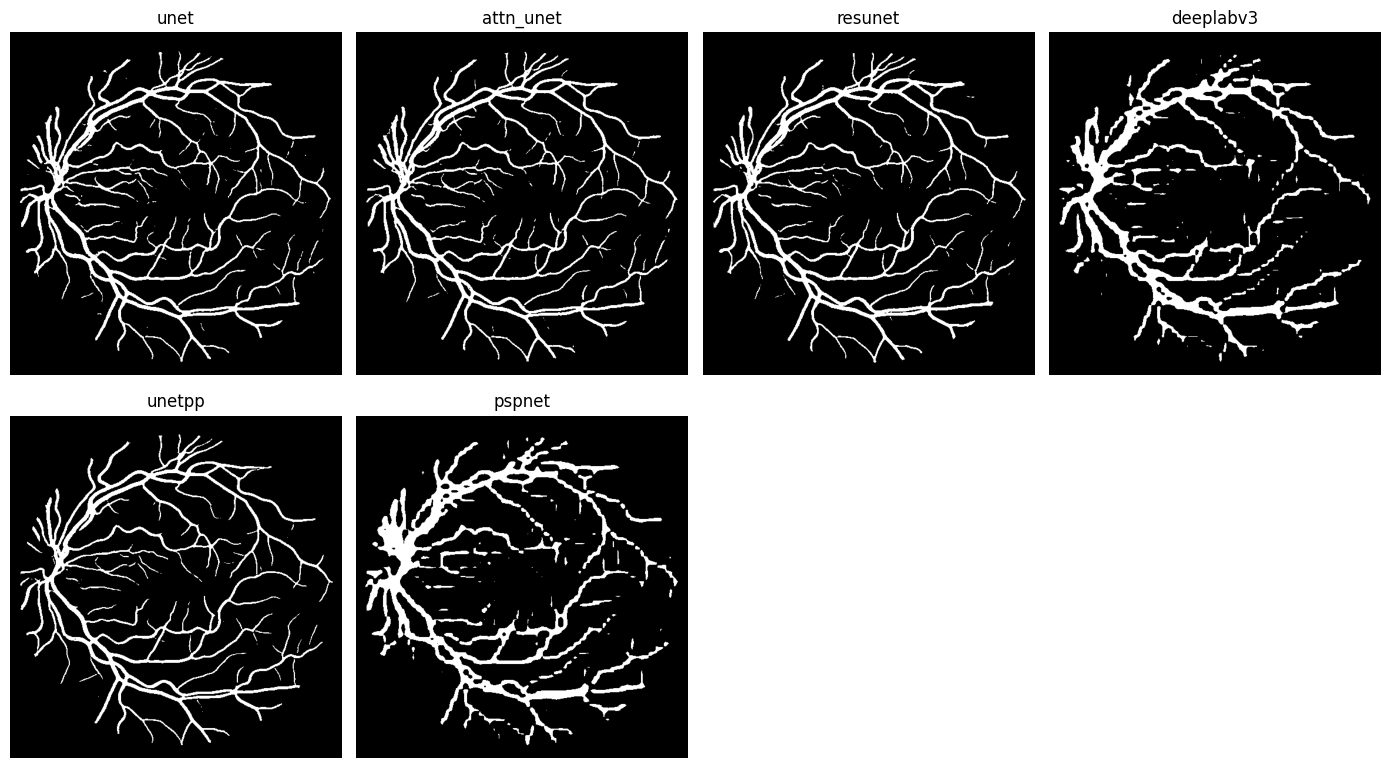

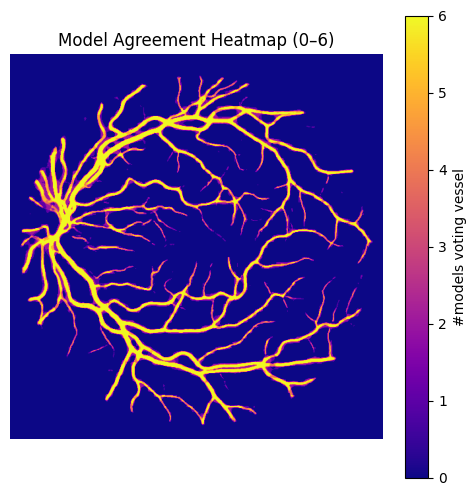

       model  threshold  vessel_pixels  latency_ms
5     pspnet       0.45          41193       112.5
3  deeplabv3       0.50          37765      1071.9
1  attn_unet       0.50          33784       437.6
0       unet       0.30          33475       381.6
2    resunet       0.30          33304       374.2
4     unetpp       0.30          32886       909.2


In [12]:
# >>> Make differences obvious: stronger overlays, raw masks, and a vote heatmap
import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

OUTDIR = Path("/kaggle/working/multimodel_outputs")
MODELS = ["unet","attn_unet","resunet","deeplabv3","unetpp","pspnet"]

# 1) Show RAW MASKS (black/white)
plt.figure(figsize=(14,8))
for i,m in enumerate(MODELS,1):
    mask = cv2.imread(str(OUTDIR/f"mask_{m}.png"), 0)
    plt.subplot(2,4,i); plt.imshow(mask, cmap="gray"); plt.title(m); plt.axis('off')
plt.tight_layout(); plt.savefig(OUTDIR/"masks_mosaic.png"); plt.show()

# 2) Stronger overlays (cyan + higher alpha)
orig = cv2.imread(str(OUTDIR/"overlay_unet.png"))  # any overlay just to get path
# Reload the original fundus from the earlier step:
fundus_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/images/01_test.tif"
fundus = cv2.imread(fundus_path)

for m in MODELS:
    mask = cv2.imread(str(OUTDIR/f"mask_{m}.png"), 0)
    overlay = fundus.copy()
    overlay[mask>0] = (255,255,0)  # cyan
    strong = cv2.addWeighted(fundus, 0.5, overlay, 0.5, 0)
    cv2.imwrite(str(OUTDIR/f"overlay_strong_{m}.png"), strong)

# 3) Vote / disagreement heatmap (0..6 models say "vessel")
stack = []
for m in MODELS:
    stack.append((cv2.imread(str(OUTDIR/f"mask_{m}.png"), 0) > 0).astype(np.uint8))
vote = np.sum(np.stack(stack, axis=0), axis=0)  # 0..6
plt.figure(figsize=(6,6))
plt.imshow(vote, cmap="plasma"); plt.colorbar(label="#models voting vessel"); plt.axis('off')
plt.title("Model Agreement Heatmap (0–6)")
plt.savefig(OUTDIR/"vote_heatmap.png"); plt.show()

# 4) Quick numbers: vessel pixel counts per model (already saved in CSV)
df = pd.read_csv(OUTDIR/"single_image_results.csv")
print(df.sort_values("vessel_pixels", ascending=False))


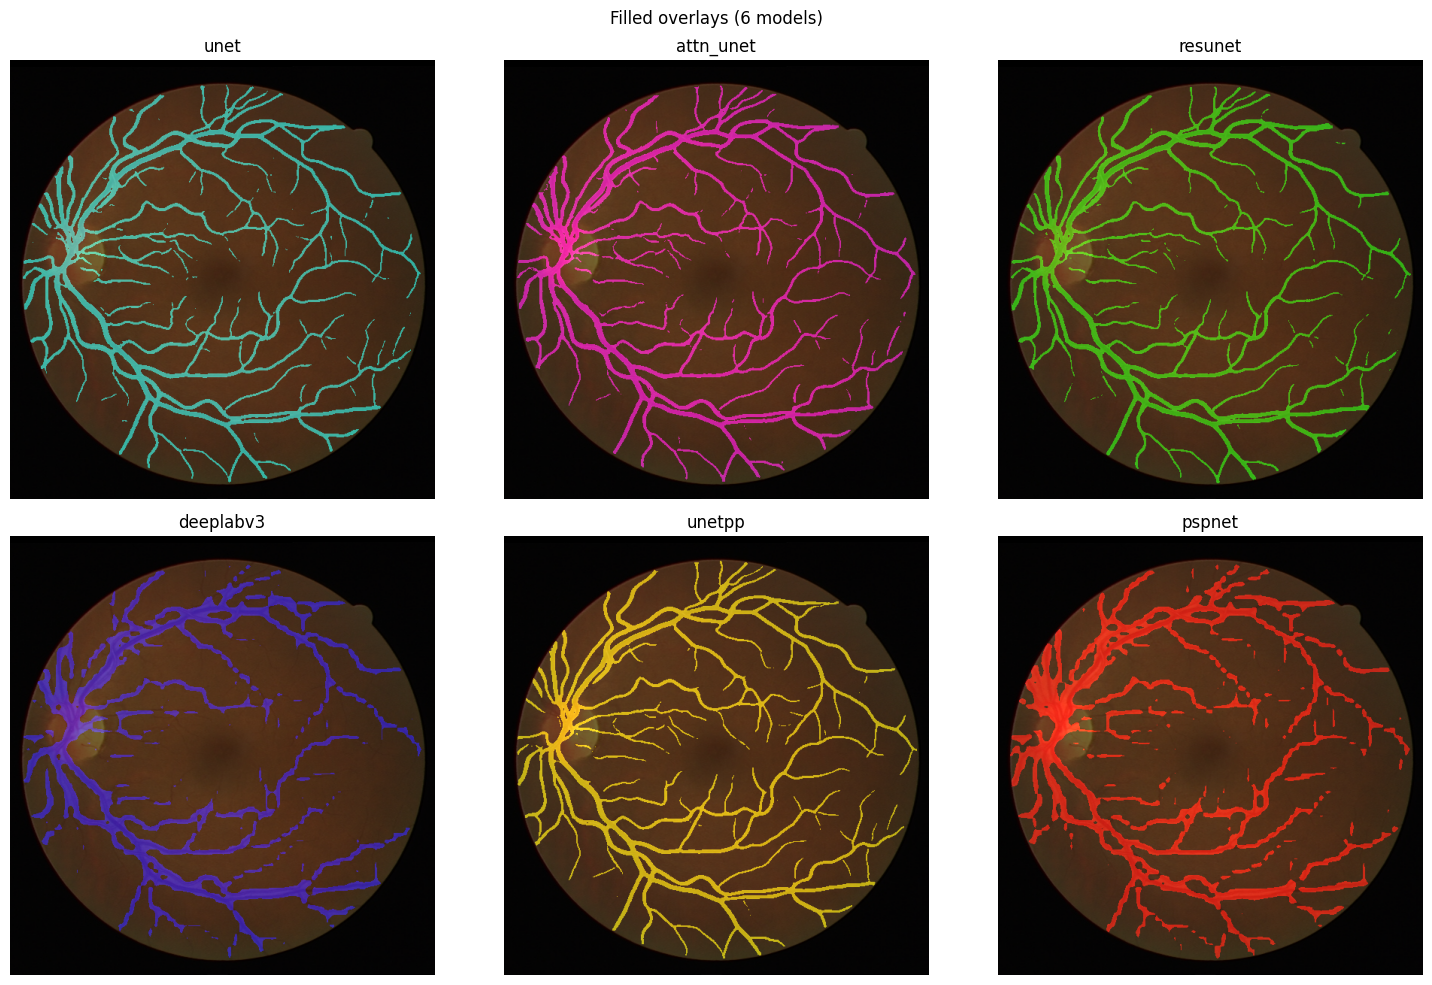

Saved: /kaggle/working/multimodel_outputs/mosaic_filled_6.png


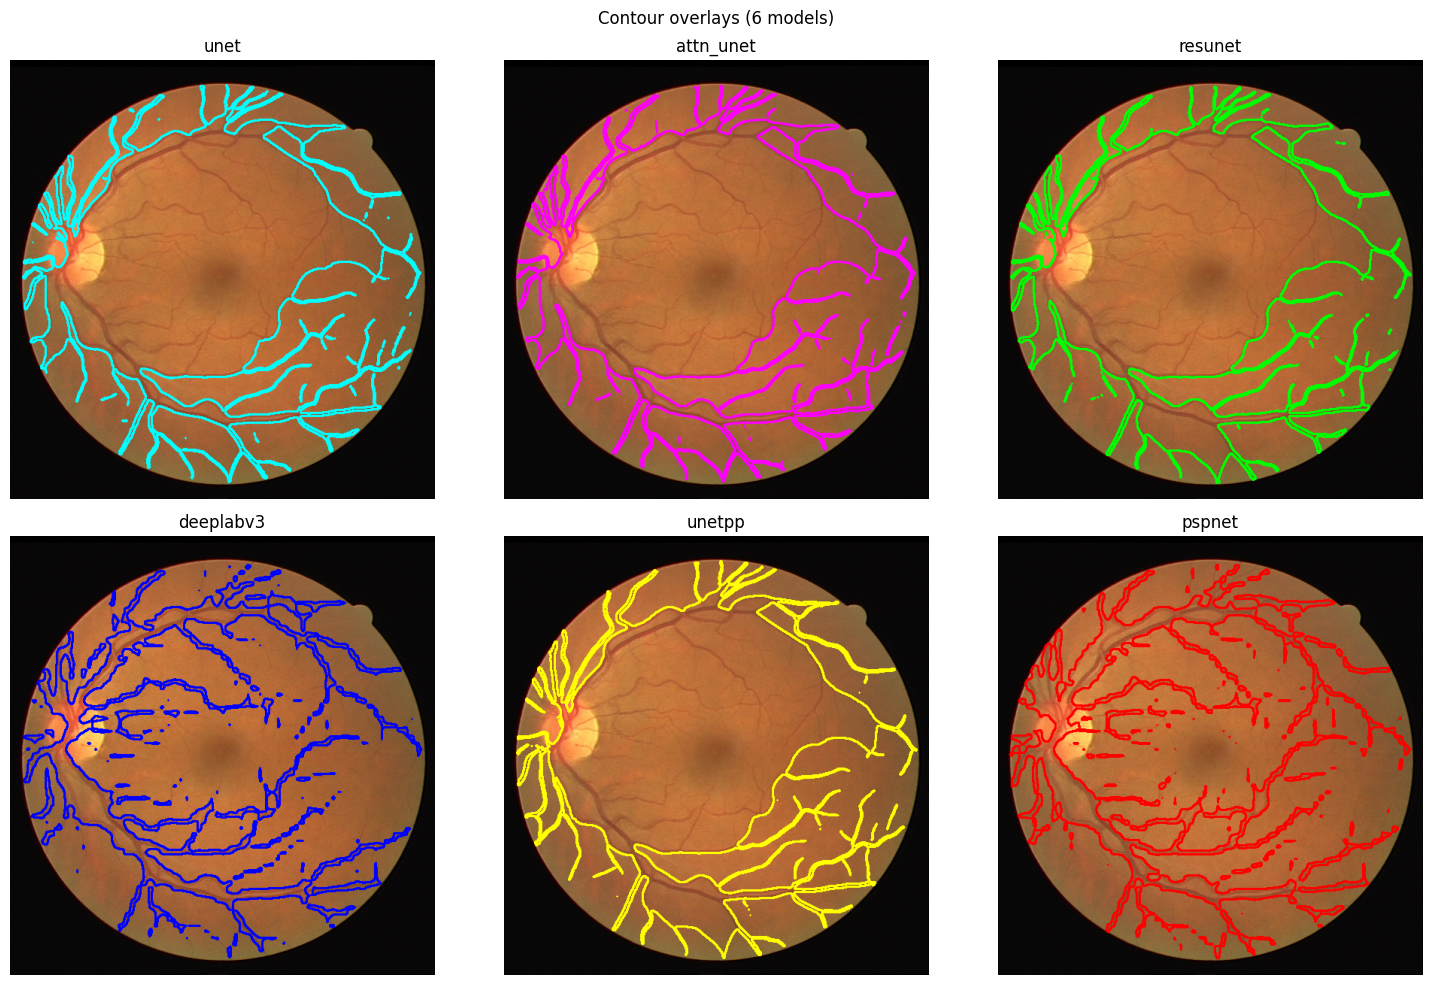

Saved: /kaggle/working/multimodel_outputs/mosaic_contour_6.png
Done. Files saved in: /kaggle/working/multimodel_outputs


In [18]:
# === Colored overlays for ALL 6 models (filled + contour) ===
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

OUTDIR  = Path("/kaggle/working/multimodel_outputs")      # where mask_{model}.png were saved
IMGPATH = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/images/01_test.tif"

MODELS = ["unet","attn_unet","resunet","deeplabv3","unetpp","pspnet"]

# OpenCV BGR colors (distinct per model)
COLMAP = {
    "unet":      (255,255,0),   # cyan
    "attn_unet": (255,0,255),   # magenta
    "resunet":   (0,255,0),     # lime
    "deeplabv3": (255,0,0),     # blue
    "unetpp":    (0,255,255),   # yellow
    "pspnet":    (0,0,255),     # red
}
ALPHA = 0.55   # blend strength
THICK = 2      # contour thickness

fundus = cv2.imread(IMGPATH, cv2.IMREAD_COLOR)
assert fundus is not None, "Could not read test image."

def save_filled(img_bgr, mask_u8, color_bgr, alpha, out_path):
    layer = np.zeros_like(img_bgr); layer[mask_u8>0] = color_bgr
    blended = cv2.addWeighted(img_bgr, 1-alpha, layer, alpha, 0)
    cv2.imwrite(str(out_path), blended)

def save_contour(img_bgr, mask_u8, color_bgr, thick, out_path):
    cnts,_ = cv2.findContours((mask_u8>0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    canvas = img_bgr.copy()
    cv2.drawContours(canvas, cnts, -1, color_bgr, thickness=thick)
    cv2.imwrite(str(out_path), canvas)

filled_paths, contour_paths = [], []
for m in MODELS:
    mpath = OUTDIR / f"mask_{m}.png"
    mask  = cv2.imread(str(mpath), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"[WARN] Missing {mpath}; skipping {m}")
        continue
    col = COLMAP[m]
    pf = OUTDIR / f"overlay_{m}_filled.png"
    pc = OUTDIR / f"overlay_{m}_contour.png"
    save_filled(fundus, mask, col, ALPHA, pf)
    save_contour(fundus, mask, col, THICK, pc)
    filled_paths.append((m, pf))
    contour_paths.append((m, pc))

# 2×3 mosaics (filled and contour)
def show_mosaic(items, title, outfile):
    plt.figure(figsize=(15,10))
    for i,(m,p) in enumerate(items[:6], 1):
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        plt.subplot(2,3,i); plt.imshow(img); plt.title(m); plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout(); 
    out = OUTDIR/outfile
    plt.savefig(out); plt.show()
    print("Saved:", out)

show_mosaic(filled_paths,  "Filled overlays (6 models)",   "mosaic_filled_6.png")
show_mosaic(contour_paths, "Contour overlays (6 models)",  "mosaic_contour_6.png")
print("Done. Files saved in:", OUTDIR)
